<a href="https://colab.research.google.com/github/gbessardon/Create_plots/blob/main/cut_reproject__plot_CORINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get the same file path as me
To get the same filepath you can open the sharable link to 
Corine: 


* Corine
https://drive.google.com/drive/folders/1YA2BdVz8psD9TGVTEITdgRfGrpt9J6Pa?usp=sharing

Then go on your drive ->Shared with me -> Right click on the folder-> add a shortcut to drive

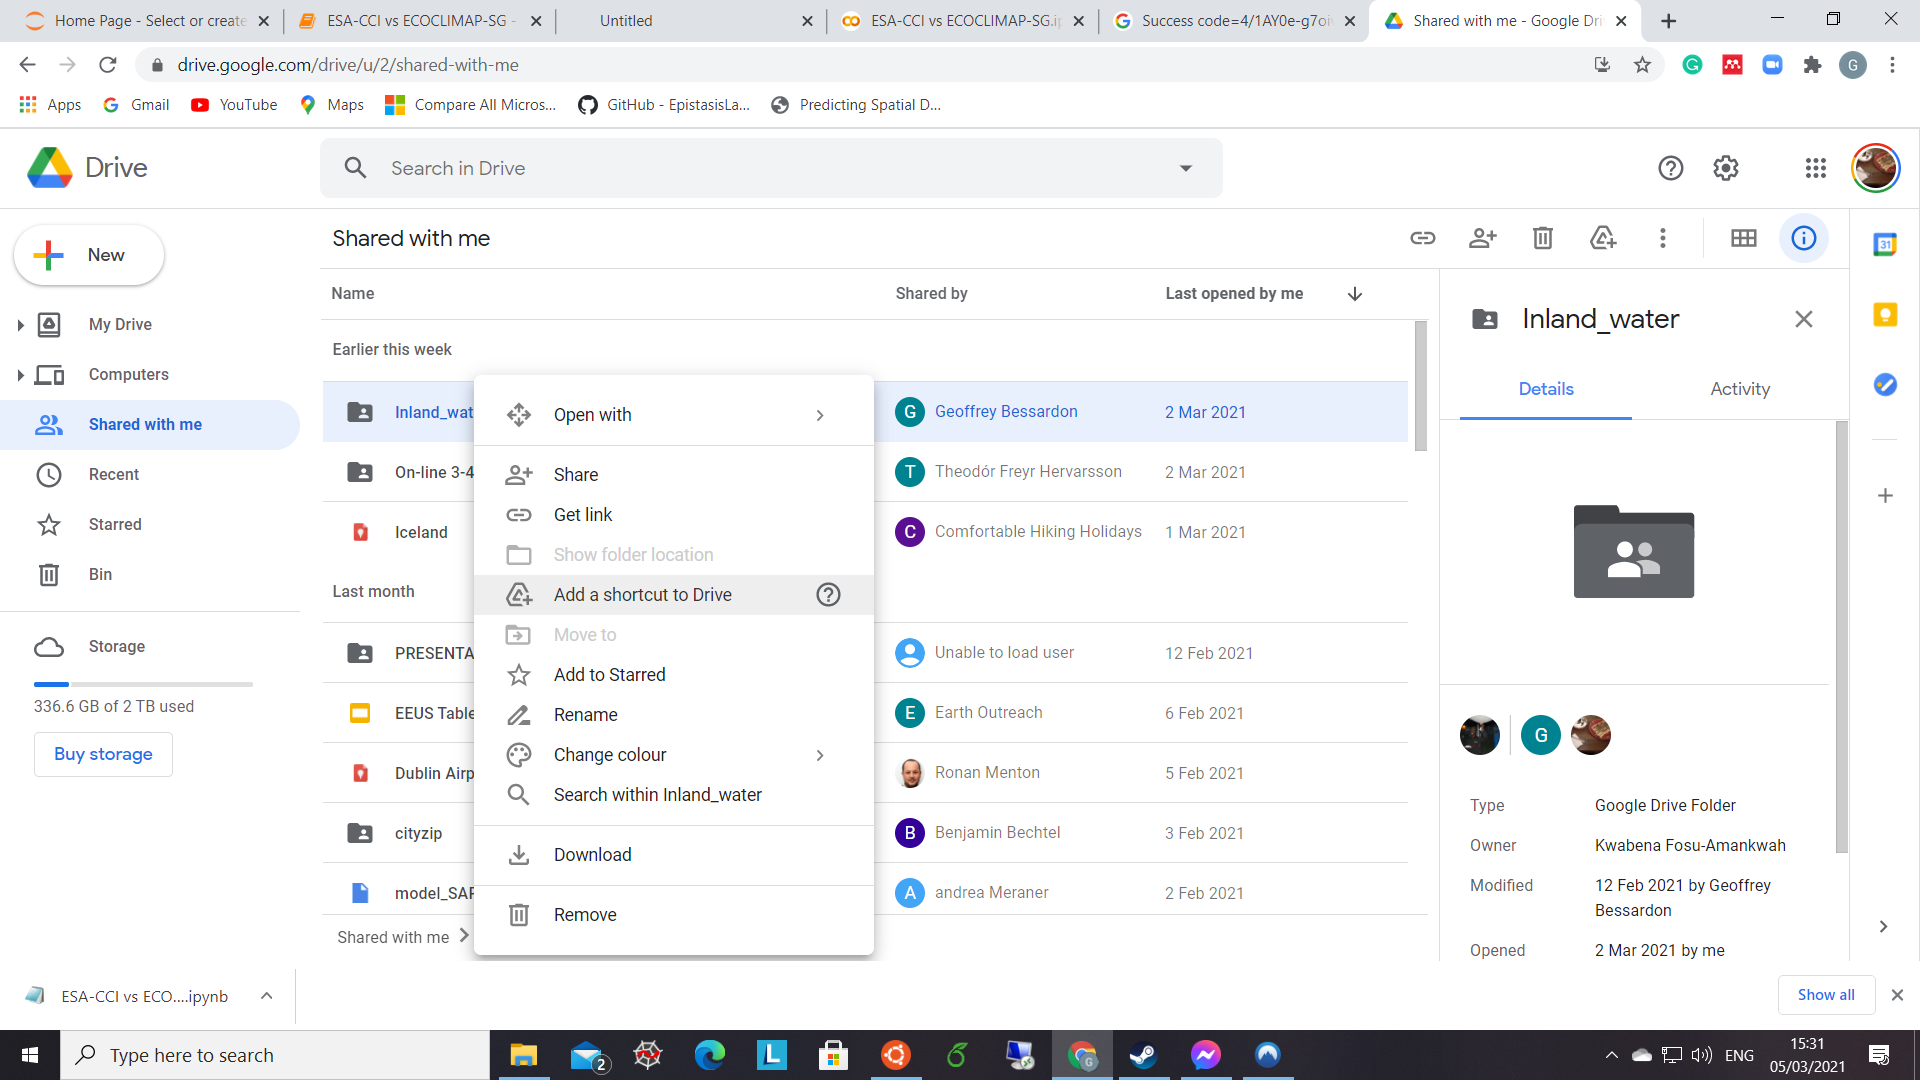

# Import Libraries

In [ ]:
!pip install netcdf4

In [ ]:
!pip install pyproj

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, ColorConverter
from osgeo import gdal
from pyproj import Proj

# Reproject and cut corine around Ireland

## Change Corine resolution to 10m and cut it in the lat lon rectangle

In [ ]:
lonmin=-11 #longitude minimale
latmax=56 # latitude maximum
lonmax=-4 #longitude maximum
latmin=50  #latitude minimal

In [ ]:
fncorine='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
res=10 # Sentinel files resolution
src_fn=fncorine
out_fn='CORINEcut10m.tif' # 10m cutted filename
ds=gdal.Open(src_fn)
gdal.Translate(out_fn,ds,projWin = [lonmin, latmax, lonmax, latmin],projWinSRS='EPSG:4326',xRes=res,yRes=res) 

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f856e3b2e10> >

### Check the resolution change (optional)

In [ ]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: CORINEcut10m.tif
Size is 29260, 76250
Coordinate System is:
PROJCS["ETRS89 / LAEA Europe",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",52],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",4321000],
    PARAMETER["false_northing",3210000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3035"]]
Origin = (3031500.000000000000000,3845600.000000000000000)
Pixel Size = (10.000000000000000,-10.000000000000000)
Metadata:
  AREA_OR_POINT=Area
  

## Change 10 m corine file  to lat/lon projection

In [ ]:
projection='EPSG:4326' # EPSG code for lat/lon
file10m='CORINEcut10m.tif'
out_fn='CORINE10mlatlon.tif'
ds=gdal.Open(file10m)
gdal.Warp(out_fn,ds,dstSRS=projection)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f855570ae10> >

### Check the projection change (optional)

In [ ]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: CORINE10mlatlon.tif
Size is 62011, 64216
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-11.001340813206026,56.679857477098665)
Pixel Size = (0.000112890837366,-0.000112890837366)
Metadata:
  AREA_OR_POINT=Area
  DataType=Thematic
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -11.0013408,  56.6798575) ( 11d 0' 4.83"W, 56d40'47.49"N)
Lower Left  ( -11.0013408,  49.4304595) ( 11d 0' 4.83"W, 49d25'49.65"N)
Upper Right (  -4.0008671,  56.6798575) (  4d 0' 3.12"W, 56d40'47.49"N)
Lower Right (  -4.0008671,  49.4304595) (  4d 0' 3.12"W, 49d25'49.65"N)
Center      (  -7.5011040,  53.0551585) (  7d30' 3.97"W, 53d 3'18.57"N)
Band 1 Block=62011x1 Type=Byte, ColorInterp=Gray
  NoData Value=-128
  Me

# Plot Corine

### function to get the corine data

In [ ]:
def get_data(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

### Function to read the legnd file

In [ ]:
#### reads the legend inputs 
def read_legend_file(file_legend):
  data=open(file_legend)
  text=[t for t in data]
  covernum=[int(d.split(',')[0]) for d in text]
  colors=[tuple((int(d.split(',')[1])/255.0,int(d.split(',')[2])/255.0,int(d.split(',')[3])/255.0,int(d.split(',')[4])/255.0)) for d in text]
  covername=[d.split(',')[5] for d in text]
  return(data,text,covernum,colors,covername)

### function to adjust the data to make it correspond to the legend

In [ ]:
#Converts the dataset to covername list index then Dplot=0 correspond to covername[0] ... Dplot[44] correspond to covername[44] 
# It is just easier to plot
def Adjustdatasetforploting(D,covernum):
  Dplot=D
  for i,fv in enumerate(covernum):
      Dplot[np.where(D==fv)]=i
  Dplot[Dplot==128]=44 ### put the no data values (128) to 44 (sea and ocean)
  return Dplot

### Function to create the colormap

In [ ]:
def corinecolormap(colors):
  c=ColorConverter().to_rgb
  rgbc=[c(col) for col in colors]
  newcmap=ListedColormap(rgbc)
  return(newcmap)

# Main

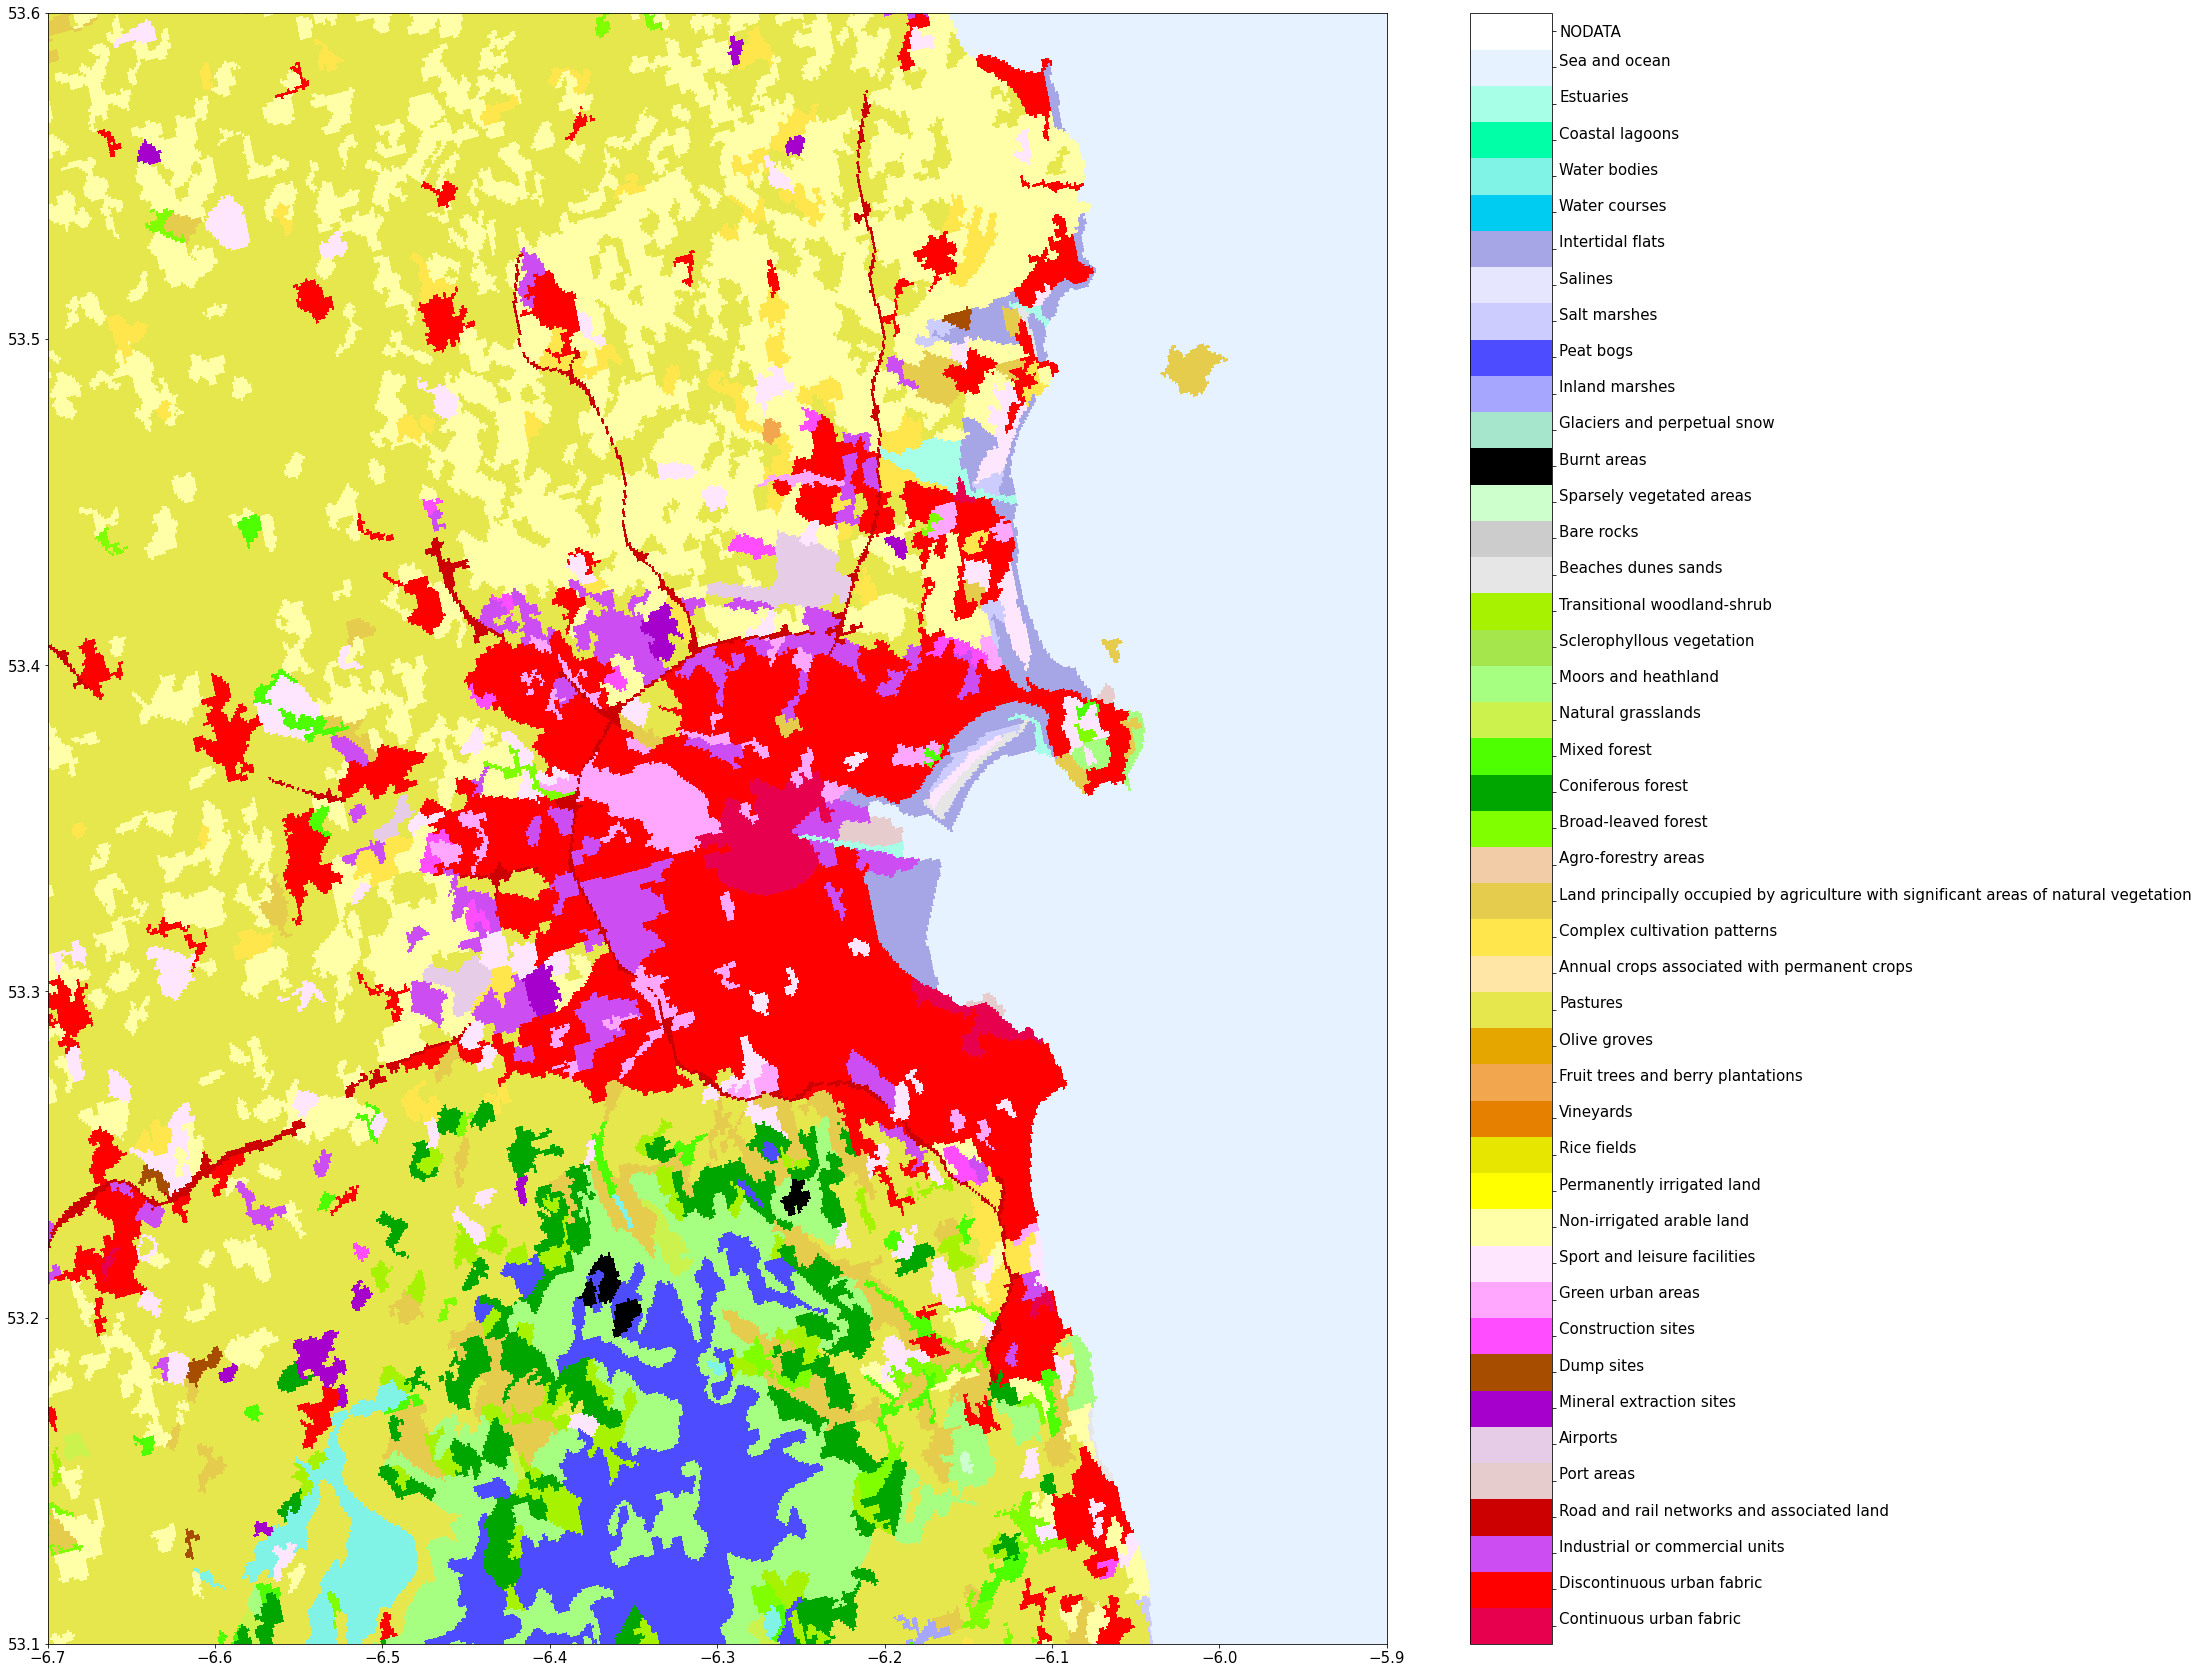

In [ ]:
latmax=53.6
latmin=53.1
lonmax=-5.9
lonmin=-6.7
fname='CORINE10mlatlon.tif' # the name of the 10m file in lat lon projection
(LAT,LON,D)=get_data(fname,latmax,latmin,lonmax,lonmin)
# read the legend metadata file
file_legend='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'
(data,text,covernum,colors,covername)=read_legend_file(file_legend)
# Adjust the dataset for easier plotting
Dplot=Adjustdatasetforploting(D,covernum)
# Create the colormap
newcmap=corinecolormap(colors)

fig, axs = plt.subplots(1, 1,figsize=(30, 30))
ax1=axs
LONg, LATg = np.meshgrid(LON, LAT)
c=ax1.pcolormesh(LONg,LATg,Dplot-1,cmap=newcmap,vmin=0,vmax=len(covernum))
ax1.set_xlim(lonmin,lonmax)
ax1.set_ylim(latmin,latmax)
cb=plt.colorbar(c, ax=ax1, ticks=np.arange(0.5,len(covernum)),extendfrac='auto', spacing='proportional')   
cb.set_ticklabels(covername)
cb.ax.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
fig.savefig('CORINE_plot.png',format='png',quality=95,bbox_inches='tight')